**マスク装着の有無のCNNによる分類**

**参考**
*   https://hajimerobot.co.jp/ai/cnn/
*   https://qiita.com/yakisobamilk/items/686d6ad5ae3285aec639

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten,MaxPooling2D,Conv2D
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

In [ ]:
keras.__version__

'2.6.0'

**訓練画像、検証画像、テスト画像のディレクトリ**

In [ ]:
# 分類クラス
classes = ['WithoutMask', 'WithMask']
nb_classes = len(classes)
batch_size_for_data_generator = 20

base_dir = '/content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset'

train_dir = base_dir+'/train'
validation_dir = base_dir+'/validation'
test_dir = base_dir+'/test'

train_WithoutMask_dir = train_dir+'/WithoutMask'
train_WithMask_dir = train_dir+ '/WithMask'

validation_WithoutMask_dir = validation_dir+ '/WithoutMask'
validation_WithMask_dir = validation_dir+ '/WithMask'

test_WithoutMask_dir = test_dir+ '/WithoutMask'
test_WithMask_dir = test_dir+ '/WithMask'

# 平均ぐらいの画像サイズがいいらしい
img_rows, img_cols = 256, 256

**画像データの数を確認する**

In [ ]:
print('total training WithoutMask images:', len(os.listdir(train_WithoutMask_dir)),train_WithoutMask_dir)
print('total training WithMask images:', len(os.listdir(train_WithMask_dir)),train_WithMask_dir)
print('\n')
print('total validation WithoutMask images:', len(os.listdir(validation_WithoutMask_dir)),validation_WithoutMask_dir)
print('total validation WithMask images:', len(os.listdir(validation_WithMask_dir)),validation_WithMask_dir)
print('\n')
print('total test WithoutMask images:', len(os.listdir(test_WithoutMask_dir)),test_WithoutMask_dir)
print('total test WithMask images:', len(os.listdir(test_WithMask_dir)),test_WithMask_dir)

total training WithoutMask images: 5000 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/train/WithoutMask
total training WithMask images: 5040 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/train/WithMask


total validation WithoutMask images: 400 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/validation/WithoutMask
total validation WithMask images: 400 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/validation/WithMask


total test WithoutMask images: 509 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/test/WithoutMask
total test WithMask images: 483 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/test/WithMask


**ImageDataGeneratorを使って画像データを拡張する**

*   rescale：画素値を変換する[0,1]で正規化？
*   sher_range：せん断 (shear transformation) する。平行四辺形のような感じ
*   zoom_range：拡大縮小をする。=0.2にすると[1 - 0.2, 1 + 0.2]の範囲でランダムに拡大縮小する。
*   horizontal_flip：=Trueでランダム左右反転



In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(img_rows, img_cols),color_mode='rgb',classes=classes,class_mode='categorical',batch_size=256,shuffle=True)

Found 10040 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = test_datagen.flow_from_directory(directory=validation_dir,target_size=(img_rows, img_cols),color_mode='rgb',classes=classes,class_mode='categorical',batch_size=32,shuffle=True)

Found 800 images belonging to 2 classes.


**CNNモデル**

*   畳み込み層

    フィルタ数、フィルタサイズ(3,3),(5,5)が多い、活性化関数、input_shape=(img_rows, img_cols, 3)カラー画像なら3

    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, 3)))



*   プーリング層

    MaxPoolingで(2,2)のプールサイズで最大の数値をとる





*   全結合層

    model.add(Flatten())
    
    前までの特徴マップを1次元に変換する

    model.add(Dense(512,activation='relu'))：512個のニューロン



In [ ]:
model=Sequential()
# 畳み込み層
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
# 全結合層
model.add(Flatten())
model.add(Dense(512,activation='relu'))
# 出力層
model.add(Dense(nb_classes,activation='softmax'))
          
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [ ]:
# モデルのコンパイル
opt = Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer= opt, metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


↑from tensorflow.keras.optimizers import RMSpropじゃないと動かない

**学習**

batchSize * steps_per_epoch = 10040
(256*36)

512*18以上だとResourceExhaustedErrorが出る

batchSize * validation_steps = 800
(32*25)

batchSize2ケタ？

機械学習／ディープラーニングにおけるバッチサイズ、イテレーション数、エポック数の決め方
https://qiita.com/kenta1984/items/bad75a37d552510e4682


*   バッチサイズ：データセットのサイズが小さければ32, 64などの小さめの値、大きければ1024, 2048などの大きめの値
*   イテレーション数：バッチサイズによる
*   エポック数：損失関数の値がほぼ収束するまで

エポック数50でやって7ぐらいで収束したので

In [ ]:
history = model.fit(train_generator,steps_per_epoch=36,epochs=5,validation_data=validation_generator,validation_steps=25,verbose=1)

Epoch 1/5
36/36 [==============================] - 4461s 123s/step - loss: 0.3184 - acc: 0.8634 - val_loss: 0.1135 - val_acc: 0.9525
Epoch 2/5
36/36 [==============================] - 463s 13s/step - loss: 0.1068 - acc: 0.9606 - val_loss: 0.0712 - val_acc: 0.9775
Epoch 3/5
36/36 [==============================] - 182s 5s/step - loss: 0.0776 - acc: 0.9743 - val_loss: 0.0615 - val_acc: 0.9762
Epoch 4/5
36/36 [==============================] - 166s 5s/step - loss: 0.0623 - acc: 0.9787 - val_loss: 0.0474 - val_acc: 0.9812
Epoch 5/5
36/36 [==============================] - 163s 5s/step - loss: 0.0441 - acc: 0.9844 - val_loss: 0.0479 - val_acc: 0.9762


**実行時間**
50epochで3h

In [ ]:
# 学習結果を保存する
hdf5_file = os.path.join(base_dir, 'mask-model_cnn.hdf5')
model.save_weights(hdf5_file)

**学習推移をグラフに表示する**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

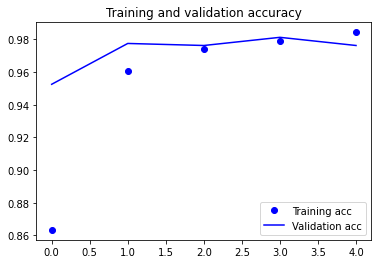

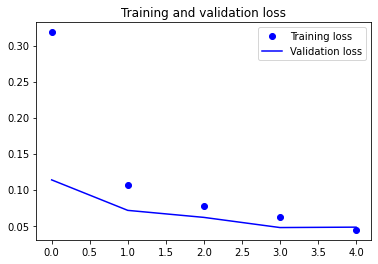

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


**テスト画像データで正答率を調べる**

In [ ]:
test_generator = test_datagen.flow_from_directory(directory=test_dir,target_size=(img_rows, img_cols),color_mode='rgb',classes=classes,class_mode='categorical',batch_size=batch_size_for_data_generator)

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 992 images belonging to 2 classes.
50/50 [==============================] - 456s 9s/step - loss: 0.0662 - acc: 0.9798
test acc: 0.9798387289047241
